In [5]:
# CIFAR_DIR = 'cifar-10-batches-py/'
import matplotlib.pyplot as plt
import cv2

In [6]:
# def unpickle(file):
#     import pickle
#     with open(file, 'rb') as fo:
#         cifar_dict = pickle.load(fo, encoding='bytes')
#     return cifar_dict

In [37]:
# dirs = ['batches.meta','data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5','test_batch']

In [38]:
# all_data = [0,1,2,3,4,5,6]

In [39]:
# for i,direc in zip(all_data,dirs):
#     all_data[i] = unpickle(CIFAR_DIR+direc)

In [40]:
# batch_meta = all_data[0]
# data_batch1 = all_data[1]
# data_batch2 = all_data[2]
# data_batch3 = all_data[3]
# data_batch4 = all_data[4]
# data_batch5 = all_data[5]
# test_batch = all_data[6]

In [41]:
# test_batch[b'data'].shape
# # test_batch[b'labels']

(10000, 3072)

In [42]:
# data_batch1.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [44]:
# X = data_batch1[b'data'].reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")

In [45]:
print(X.shape)

(10000, 32, 32, 3)


In [46]:
def one_hot_encode(vec, vals=10):
    '''
    For use to one-hot encode the 10- possible labels
    '''
    n = len(vec)
    out = np.zeros((n, vals))
    out[range(n), vec] = 1
    return out

In [47]:
class CifarHelper():
    
    def __init__(self):
        self.i = 0
        
        # Grabs a list of all the data batches for training
        self.all_train_batches = [data_batch1,data_batch2,data_batch3,data_batch4,data_batch5]
        # Grabs a list of all the test batches (really just one batch)
        self.test_batch = [test_batch]
        
        # Intialize some empty variables for later on
        self.training_images = None
        self.training_labels = None
        
        self.test_images = None
        self.test_labels = None
    
    def set_up_images(self):
        
        print("Setting Up Training Images and Labels")
        
        # Vertically stacks the training images
        self.training_images = np.vstack([d[b"data"] for d in self.all_train_batches])
        train_len = len(self.training_images)
        
        # Reshapes and normalizes training images
        self.training_images = self.training_images.reshape(train_len,3,32,32).transpose(0,2,3,1)/255
        # One hot Encodes the training labels (e.g. [0,0,0,1,0,0,0,0,0,0])
        self.training_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.all_train_batches]), 10)
        
        print("Setting Up Test Images and Labels")
        
        # Vertically stacks the test images
        self.test_images = np.vstack([d[b"data"] for d in self.test_batch])
        test_len = len(self.test_images)
        
        # Reshapes and normalizes test images
        self.test_images = self.test_images.reshape(test_len,3,32,32).transpose(0,2,3,1)/255
        # One hot Encodes the test labels (e.g. [0,0,0,1,0,0,0,0,0,0])
        self.test_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.test_batch]), 10)

        
    def next_batch(self, batch_size):
        # Note that the 100 dimension in the reshape call is set by an assumed batch size of 100
        x = self.training_images[self.i:self.i+batch_size].reshape(100,32,32,3)
        y = self.training_labels[self.i:self.i+batch_size]
        self.i = (self.i + batch_size) % len(self.training_images)
        return x, y

In [7]:
ch = CifarHelper()
ch.set_up_images()
img=cv2.imread(r"C:/Users/mayan/Desktop/train/2p.jpg", cv2.IMREAD_UNCHANGED)

In [49]:
import tensorflow as tf

In [50]:
x = tf.placeholder(tf.float32,shape=[None,32,32,3])
y_true = tf.placeholder(tf.float32,shape=[None,10])

In [51]:
hold_prob = tf.placeholder(tf.float32)

In [52]:
#Helper Function

#init weights
def init_weights(shape):
    init_random_distribution = tf.truncated_normal(shape,mean=0,stddev=0.1)
    return tf.Variable(init_random_distribution)

#init bias
def init_bias(shape):
    init_bias_value = tf.constant(0.1,shape=shape)
    return tf.Variable(init_bias_value)

#conv2d
def conv2d(x,W):
    #x -- > [batch,H,W,channels]
    #W -- > [filter H, filter W, Channels In, Channels Out]
    return tf.nn.conv2d(x,W,strides=[1,1,1,1],padding='SAME')

#pooling
def max_pool_2by2(x):
    return tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

#convolutional layer
def convolutional_layer(input_x,shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x,W)+b)

#fully connected layer
def normal_full_layer(input_layer,size):
    return tf.contrib.layers.fully_connected(input_layer, size, activation_fn=None)

In [53]:
convo_1 = convolutional_layer(x,shape=[4,4,3,32])
convo_1_pooling = max_pool_2by2(convo_1)

In [54]:
convo_2 = convolutional_layer(convo_1_pooling,shape=[5,5,32,64])
convo_2_pooling = max_pool_2by2(convo_2)


convo_3 = convolutional_layer(convo_2_pooling,shape=[5,5,64,128])
convo_3_pooling = max_pool_2by2(convo_3)

In [55]:
convo_2_flat = tf.contrib.layers.flatten(convo_3_pooling)

In [56]:
hold_prob = tf.placeholder(tf.float32)

In [57]:
full_layer_one = tf.contrib.layers.fully_connected(convo_2_flat, 128, activation_fn=None)
full_one_dropout = tf.nn.dropout(full_layer_one,keep_prob=hold_prob)
full1 = tf.layers.batch_normalization(full_one_dropout)

In [58]:
full_layer_two = tf.contrib.layers.fully_connected(full1, 256, activation_fn=None)
full_two_dropout = tf.nn.dropout(full_layer_two,keep_prob=hold_prob)
full2 = tf.layers.batch_normalization(full_two_dropout)

In [59]:
full_layer_three = tf.contrib.layers.fully_connected(full2, 512, activation_fn=None)
full_three_dropout = tf.nn.dropout(full_layer_three,keep_prob=hold_prob)
full3 = tf.layers.batch_normalization(full_three_dropout)

In [60]:
full_layer_four = tf.contrib.layers.fully_connected(full3, 1024, activation_fn=None)
full_four_dropout = tf.nn.dropout(full_layer_four,keep_prob=hold_prob)
full4 = tf.layers.batch_normalization(full_four_dropout)

In [61]:
y_pred = tf.contrib.layers.fully_connected(full4, 10, activation_fn=None)


In [62]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true,logits=y_pred))

In [63]:
train=tf.train.AdamOptimizer(learning_rate=0.001).minimize(cross_entropy)

In [64]:
init = tf.global_variables_initializer()


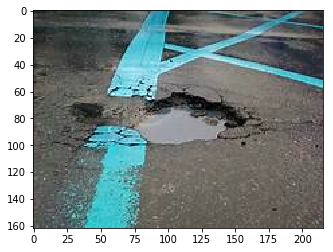

In [8]:
# plt.imshow(ch.test_images[9])
# set = ch.test_images[9].reshape(1,32,32,3)
# set_label = ch.test_labels[9].reshape(1,10)
# print(set_label)
# val = tf.placeholder(tf.float32,shape=[None,10])
plt.imshow(img)

In [ ]:
# steps = 210
# with tf.Session() as sess:
#     sess.run(init)
#     for i in range(steps):
#         batch = ch.next_batch(100)
#         sess.run(train,feed_dict={x:batch[0],y_true:batch[1],hold_prob:0.7})
#         if i%100 == 0:
#             print("On Step: {}".format(i))
#             print("Acc:")
#             matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))
#             acc = tf.reduce_mean(tf.cast(matches,tf.float32))
#             print(sess.run(acc,feed_dict={x:set,y_true:set_label,hold_prob:1.0}))
#             print(tf.argmax(sess.run(y_pred,feed_dict={x:set,y_true:set_label,hold_prob:1.0}),1).eval())
#             print("\n")

In [66]:
steps = 4000
sess=tf.InteractiveSession()
sess.run(init)
for i in range(steps):
    batch = ch.next_batch(100)
    print(batch[0].shape)
    sess.run(train,feed_dict={x:batch[0],y_true:batch[1],hold_prob:0.7})
#     if i%100 == 0:
#         print("On Step: {}".format(i))
#         print("Acc:")
#         matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))
#         acc = tf.reduce_mean(tf.cast(matches,tf.float32))
#         print(sess.run(acc,feed_dict={x:set,y_true:set_label,hold_prob:1.0}))
#             print(tf.argmax(sess.run(y_pred,feed_dict={x:set,y_true:set_label,hold_prob:1.0}),1).eval())
#             print("\n")

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 

(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 

(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 

(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 

(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 

(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 

(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 

(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 

(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 

In [ ]:
print("Acc:")
matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))
acc = tf.reduce_mean(tf.cast(matches,tf.float32))
print(sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels,hold_prob:1.0}))

In [ ]:
plt.imshow(ch.test_images[9])
set = ch.test_images[9].reshape(1,32,32,3)
set_label = ch.test_labels[9].reshape(1,10)
print(set_label)
#val = tf.placeholder(tf.float32,shape=[None,10])
print("Acc:")
matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))
acc = tf.reduce_mean(tf.cast(matches,tf.float32))
print(sess.run(acc,feed_dict={x:set,y_true:set_label,hold_prob:1.0}))
print("Predicted :")
print(tf.argmax(sess.run(y_pred,feed_dict={x:set,y_true:set_label,hold_prob:1.0}),1).eval())